In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz as gr

import statsmodels.formula.api as smf

from econml.dml import CausalForestDML

from sklearn.model_selection import train_test_split

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Abstract

In this post, we present a scenario where a university seeks to identify the causal effects of sports passes on alumni donation likelihood. Using a synthetic dataset mimicking a random sample of alumni five years post-graduation, we explore the data to gather insights and illustrate the flow of causality via a Directed Acyclic Graph (DAG). We then demonstrate how a university can calculate these causal effects using two different models: logistic regression and causal forests. Finally, we discuss how a university might strategically utilize these findings to increase philanthropic activity among alumni.

# Introduction

A major source of revenue for universities is through donations from alumni [@Schwartz_2024_UScolleges]. These contributions are largely used to provide financial assistance to students but can also support other causes, including university operations, research funding, and facility construction. Maximizing alumni engagement and encouraging them to give back is a key objective for all universities. To achieve this, universities attempt to create meaningful touchpoints that strengthen relationships with alumni. One significant avenue for fostering these connections is through sports programs.

University sports programs have become an important lever in creating alumni loyalty [@PEGLtd_2024_Bleachers]. They provide the university with good publicity for recruiting new students, help establish strong alumni pipelines, and maintaining existing alumni relationships. From merchandise to games and special dinners, sports programs offer universities a powerful way to instill pride in their alumni, encouraging them to contribute to the university's mission.

The central question then becomes: How can universities foster this sense of pride in students during their time on campus and sustain it post-graduation? If sports programs serve as a bridge between alumni and the university, how can we ensure students are engaged with these programs so that, when the time is appropriate, they are eager to become donors who support and sustain the university?

# Encouraging Engagement: Sports Passes

A common approach to encourage student engagement with sports programs is a one-for-all pass. Purchased for a flat fee at the beginning of the school year, these passes grant students access to any home sporting event within designated student seating. This not only serves as a valuable revenue stream for the university but also creates meaningful student memories at games. From pre-game fan activities to in-game engagement and post-game celebrations, these sport passes actively encourage students throughout their university tenure to immerse themselves in the exciting atmosphere of the university.

Since students have a direct avenue to become acquainted with university sports via these passes, we can now formulate our research question: **Do sports passes cause an increase in the likelihood of alumni becoming donors?** It is crucial that we move beyond simply observing a correlation between sports pass purchase and alumni donations. Instead, our goal is to identify if these passes represent a true lever that universities can strategically utilize to influence the philanthropic behavior of their alumni.

# Discovering Causality

## Gathering Data

In order to attempt to establish a causal relationship, we first need to identify the nature of our data. The gold standard for establishing causal relationships is performing a **randomized controlled trial (RCT)**. However, in our situation, this is infeasible. We would not want to randomly assign sports passes to some students and withhold them from others, as this would significantly reduce potential revenue from pass sales. Furthermore, we cannot guarantee that students assigned a pass would actually utilize it.

From a university's perspective, we have a long history of selling sports passes and have significantly enhanced our ability to track student activity through student IDs across various campus engagements. While we lack experimental data, we have a plethora of observational data. Although extracting causal relationships from observational data is more complex, recent advancements in causal inference have made these estimates considerably more robust [@Hernan2006].

Even though we have a plethora of observational data, we still need to design a sampling strategy in order to set up our analysis correctly. To do this, we'll use a stratified sampling approach where we take equal random samples across different university majors. Furthermore, we gather other important covariates for modeling. Below is a sample of our gathered data. 

In [2]:
#Define data gen function
def gen_data(n_obs, r_seed=42):
    np.random.seed(r_seed)
    
    data_dict = {
        'major': [],
        'GPA': [],
        'gender': [],
        'alumni_parents': [],
        'played_intramurals': [],
        'current_salary': [],
        'sports_pass': [],
        'has_donated': []
    }
    
    major_sal_dict = {
        'Life Science': {'mean': 70, 'sd': 10},
        'Engineering': {'mean': 90, 'sd': 5},
        'Business': {'mean': 100, 'sd': 10}, 
        'Humanities': {'mean': 60, 'sd': 15}, 
        'Computer Science': {'mean': 100, 'sd': 5}
    }
    
    major_sport_dict = {
        'Life Science': {'low': 0, 'high': .3},
        'Engineering': {'low': 0, 'high': .2},
        'Business': {'low': .3, 'high': .4}, 
        'Humanities': {'low': .2, 'high': .3}, 
        'Computer Science': {'low': .1, 'high': .3}
    }
    
    major_don_dict = {
        'Life Science': {'low': 0, 'high': .2},
        'Engineering': {'low': 0, 'high': .2},
        'Business': {'low': .15, 'high': .25}, 
        'Humanities': {'low': .1, 'high': .2}, 
        'Computer Science': {'low': .1, 'high': .3}
    }
    
    for n in range(n_obs):
        major = np.random.choice(list(major_sal_dict.keys()))
        gpa = round(min(4, np.random.normal(3.0, 0.5)), 2)
        gender = np.random.choice(['f', 'm'])
        alumni = np.random.choice([0, 1])
        intramural = np.random.choice([0, 1])
        current_sal = round(np.random.normal(major_sal_dict[major]['mean'], major_sal_dict[major]['sd']), 2)
        
        prob_sports_pass = np.random.uniform(major_sport_dict[major]['low'], major_sport_dict[major]['high'])
        if alumni == 1:
            prob_sports_pass += .2
        if intramural == 1:
            prob_sports_pass += .1
        if gpa > 3.5: 
            prob_sports_pass -= .15
            
        sports_pass = 0
        if prob_sports_pass > np.random.uniform():
            sports_pass = 1
        
        prob_donated = np.random.uniform(major_don_dict[major]['low'], major_don_dict[major]['high'])
        if major in ['Humanities', 'Business']:
            prob_donated += .15
        if alumni == 1:
            prob_donated += .15
        if sports_pass == 1: 
            prob_donated += .3
        if current_sal > 110:
            prob_donated += .15
        if current_sal < 100:
            prob_donated -= .25
            
        donated = 0
        if prob_donated > np.random.uniform():
            donated = 1
        
        data_dict['major'].append(major)
        data_dict['GPA'].append(gpa)
        data_dict['gender'].append(gender)
        data_dict['alumni_parents'].append(alumni)
        data_dict['played_intramurals'].append(intramural)
        data_dict['current_salary'].append(current_sal)
        data_dict['sports_pass'].append(sports_pass)
        data_dict['has_donated'].append(donated)
        
    return pd.DataFrame(data_dict)

In [3]:
#Generate data
df = gen_data(3000)

In [4]:
#Show head of df
df.head()

,major,GPA,gender,alumni_parents,played_intramurals,current_salary,sports_pass,has_donated
0,Humanities,2.44,f,0,0,64.78,0,0
1,Computer Science,2.71,f,0,1,97.37,1,0
2,Engineering,2.87,m,0,1,89.18,0,0
3,Computer Science,2.85,f,1,1,99.85,1,0
4,Humanities,2.99,f,0,1,44.13,1,0


The samples we gathered were from alumni who graduated five years ago. Our response variable *has_donated* is 1 for donated and 0 for no donation. Our treatment variable *sports_pass* is also binary where 1 is for purchased a sports pass and 0 for no. Since we are dealing with establishing causality, we want to include potential confounders as part of the dataset. To account for this, we gathered data on alumni majors, GPA, gender, if their parents are alumni, if they played intramurals, and their current salary. Our data in total contains 3000 observations.

## Exploring the Data

Before diving into the causal models, we first explore the data to see if there is any potential evidence of causality. Our first graph @fig-eda-1 shows the count between non-donors and donors in our dataset. 

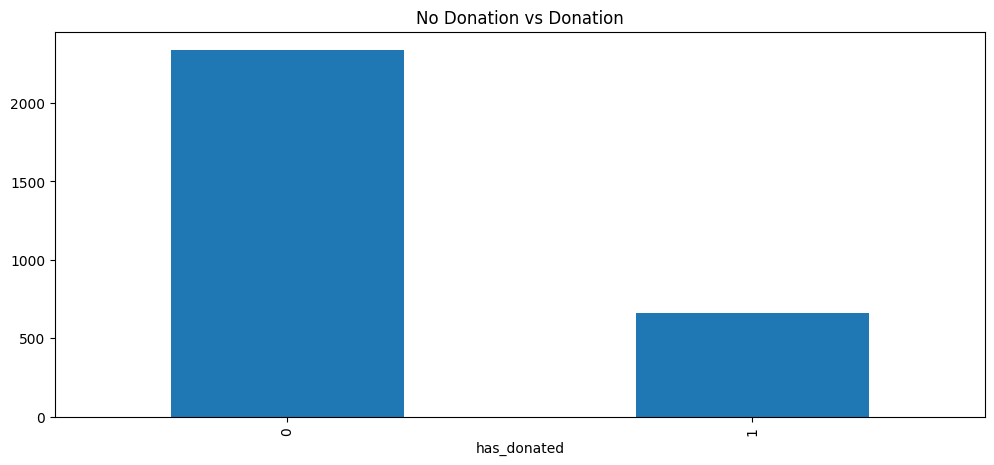

In [5]:
#| label: fig-eda-1
#| fig-cap: "Count of Non-Donors vs Donors"

#Show split between donated and not donated in the dataset
fig, ax = plt.subplots(figsize=(12,5))

df.groupby('has_donated').size().plot(kind='bar', ax=ax, title='No Donation vs Donation');

@fig-eda-1 clearly shows that the majority of our observations are non-donors. We can see how these numbers are across different majors in @fig-eda-2. 

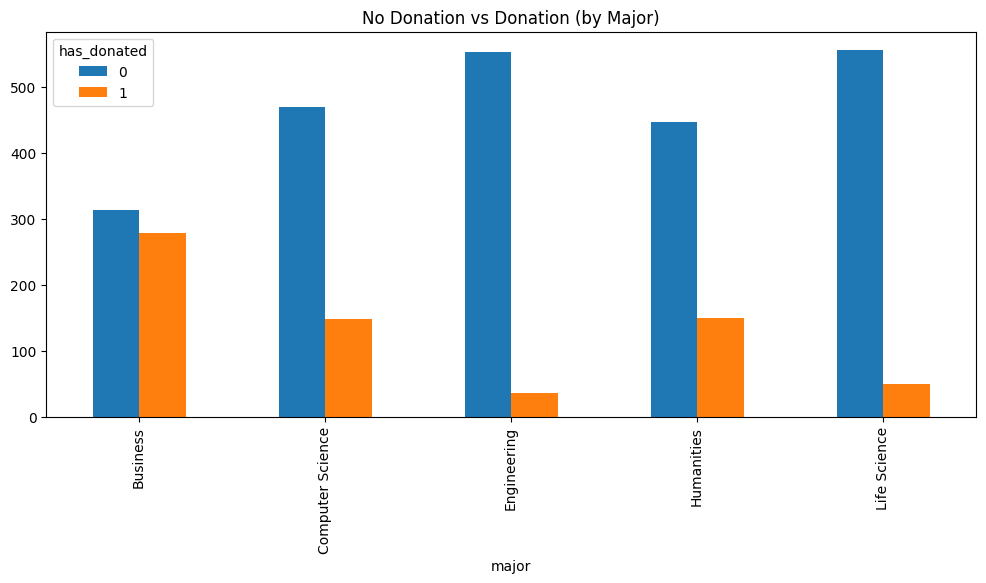

In [6]:
#| label: fig-eda-2
#| fig-cap: "Count of Non-Donors vs Donors by Major"

#Show split between donated and not donated among different majors
fig, ax = plt.subplots(figsize=(12,5))

df.groupby(['major', 'has_donated']).size().unstack().plot(kind='bar', ax=ax, title='No Donation vs Donation (by Major)');

@fig-eda-2 reveals an interesting relationship between donors and major. It seems that, according to our sample, donation likelihood across majors varies. Business majors appear to have the highest percent of donors whereas engineering appears to have the lowest. @fig-eda-3 continues this investigation by seeing the proportion of alumni who purchased sports passes in their undergrad split by major. 

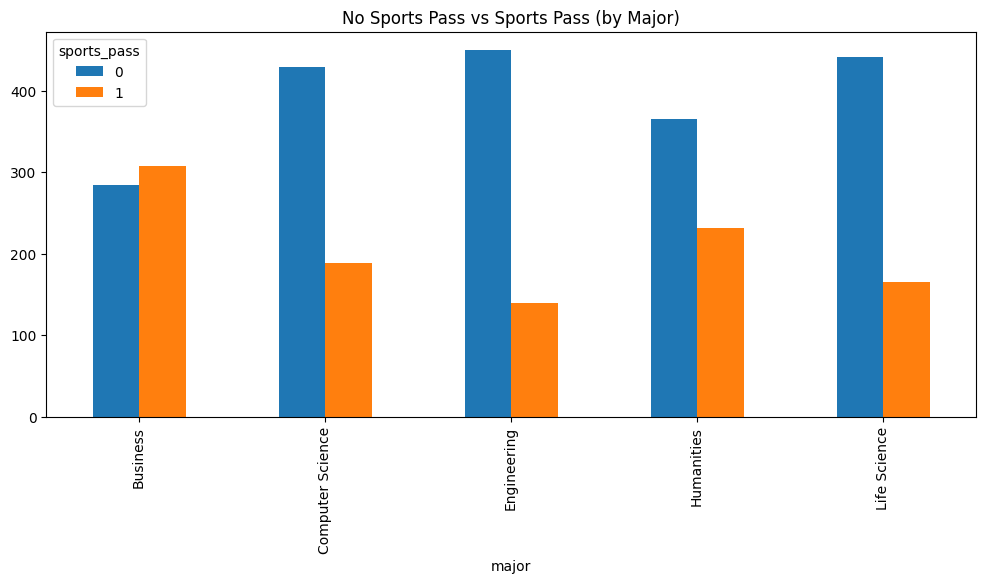

In [7]:
#| label: fig-eda-3
#| fig-cap: "Count of Non-Sports Pass Holders vs Sports Pass Holders by Major"

#Show sports pass by major
fig, ax = plt.subplots(figsize=(12,5))

df.groupby(['major', 'sports_pass']).size().unstack().plot(kind='bar', ax=ax, title='No Sports Pass vs Sports Pass (by Major)');

@fig-eda-3 reveals an interesting finding: Business majors exhibit the highest proportion of sports pass holders, with engineering majors once again showing the lowest. While we can't immediately attribute the higher number of donors from business majors solely to their high proportion of  sports pass ownership, we are encouraged by this finding as it presents a plausible explanation for the observed donation patterns. To further investigate this possibility, we can look at @fig-eda-4.

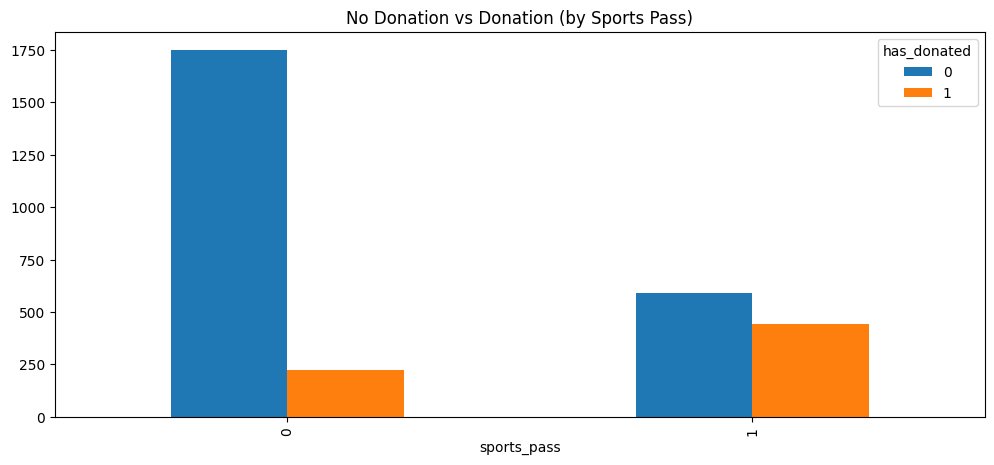

In [8]:
#| label: fig-eda-4
#| fig-cap: "Count of Non-Donors vs Donors by Sports Pass"

#Show donation by sportspass
fig, ax = plt.subplots(figsize=(12,5))

df.groupby(['sports_pass', 'has_donated']).size().unstack().plot(kind='bar', ax=ax, title='No Donation vs Donation (by Sports Pass)');

@fig-eda-4 is very informative. There is a much higher proportion of donors who come from those who own sports passes than those who did not own a sports pass. Again, it is too early to attribute causality as the reason behind these relationships. Nonetheless, it is once again an encouraging sign for us attempting to discover a causal relationship between sports pass and donor likelihood. For example, @fig-eda-5 shows a potential confounder to donation.

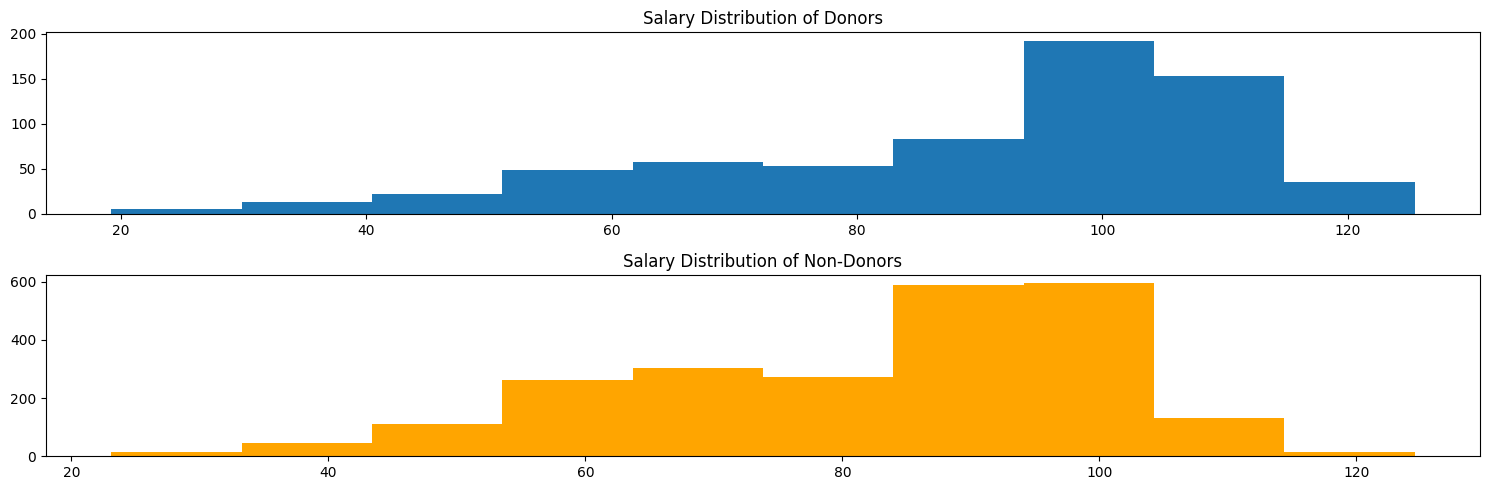

In [9]:
#| label: fig-eda-5
#| fig-cap: "Salary Distribution between Donors and Non-Donors"

#Plot distribution of salaries by people who donated vs not donated
fig, ax = plt.subplots(2, 1, figsize=(15,5))

ax[0].hist(df.query("has_donated == 1")['current_salary'])
ax[0].set_title("Salary Distribution of Donors")

ax[1].hist(df.query("has_donated == 0")['current_salary'], color='orange')
ax[1].set_title("Salary Distribution of Non-Donors")

fig.tight_layout();

fig-eda-5 shows current salary as a potential confounder. The distribution of donors appears to be more left-skewed than that of non-donors, signifying that the mean and median salary of donors are higher. While we don't know if this difference is statistically significant, it suggests that a person's current salary, rather than their sports connection to the university, could be a reason for their donation behavior.

## Illustrating the Flow of Causality

The best way to begin to understand all the potential causal influences on a response variable in observational studies is via a **directed acyclic graph (DAG)**. DAGs are the language of causal inference since we can visually see the flow of causality from our potential confounders and treatment to our response variable. @fig-dag-1 shows our proposed DAG.

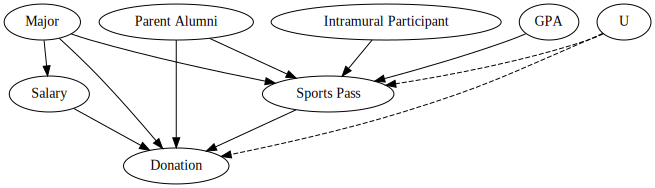

In [10]:
#| label: fig-dag-1
#| fig-cap: "DAG representing the flow of causality in our observational data"

#Show Causal DAG
g = gr.Digraph()
g.edge("Major", "Donation")
g.edge("Salary", "Donation")
g.edge("Parent Alumni", "Donation")
g.edge("Sports Pass", "Donation")

g.edge("Major", "Sports Pass")
g.edge("Parent Alumni", "Sports Pass")
g.edge("GPA", "Sports Pass")
g.edge("Intramural Participant", "Sports Pass")

g.edge("Major", "Salary")

g.edge('U', 'Sports Pass', style='dashed')
g.edge('U', 'Donation', style='dashed')

g

@fig-dag-1 clearly shows many different influences on likelihood of donation. For example, the choice of major causes the current salary which then flows into how likely an alumni is to donate. We also hypothesize the potential that those who have parents that are alumni has a causal relationship with donation and sports pass. We also illustrate the potential of unobserved confounders influencing the likelihood of purchasing sports passes and the likelihood of donating. 

To identify a causal relationship between sports pass and donation, we need to isolate the flow of causality between sports pass and donation. To do this, we need to block any backdoor paths of causality. For example, since having parents who are alumni is a cause of both donation and sports pass, this introduces a backdoor flow of causality that confounds the effects of sports pass. In total, we need to block Major and Parent Alumni to eliminate backdoor causal paths. 

Unfortunately, we can't block unobserved confounders since there is no way of measuring them. We'll have to address this problem later on in our modeling through sensitivity analysis. 

## Logistic Regression to estimate Average Treatment Effect (ATE)

After establishing our causal relationships via @fig-dag-1, we can begin to define a model that will estimate our **average treatment effect (ATE)**. A simple way we can do this is via logistic regression, as shown in @eq-log-1.

$$
\log\left(\frac{p}{1-p}\right) = \beta^{T}X
$${#eq-log-1}

$X$ is our design matrix, $\beta$ is our vector of coefficients, and the left hand side of the equation is our log-odds ratio. Logistic regression aims to maximize the log likelihood through finding the proper $\beta$ values. In other words, it aims to find the most likely $\beta$ values that would occur with the $X$ and $y$ combinations.

In our scenario, we identified that we need to include major and parent alumni in our design matrix to isolate the effects of sports pass on likelihood of donation. However, since including other covariates wouldn't introduce confoundness, we can include the rest of the covariates from @fig-dag-1. Our model output is shown below.

In [11]:
#| output: false

#Fit logistic model
model_str = "has_donated ~ sports_pass + C(major) + alumni_parents + GPA + played_intramurals + current_salary"
logit_model = smf.logit(model_str, data=df).fit()

Optimization terminated successfully.
         Current function value: 0.398011
         Iterations 7


In [12]:
#Show results of model
logit_model.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-3.9580,0.618,-6.407,0.000,-5.169,-2.747
C(major)[T.Computer Science],-0.8742,0.139,-6.285,0.000,-1.147,-0.602
C(major)[T.Engineering],-2.2845,0.209,-10.917,0.000,-2.695,-1.874
C(major)[T.Humanities],0.0752,0.237,0.318,0.751,-0.389,0.539
C(major)[T.Life Science],-1.4476,0.232,-6.234,0.000,-1.903,-0.993
sports_pass,1.4989,0.106,14.181,0.000,1.292,1.706
alumni_parents,0.9650,0.109,8.880,0.000,0.752,1.178
GPA,-0.1134,0.106,-1.065,0.287,-0.322,0.095
played_intramurals,0.0484,0.104,0.465,0.642,-0.156,0.253
current_salary,0.0289,0.005,5.729,0.000,0.019,0.039


Our primary parameter of interest is sports_pass. Our log-odds increase in donation likelihood is 1.4989, which on the odds scale about 4.47. This means that on average, holding all else constant, those with sports passes have 4.47 higher odds of donating than those who do not have sports passes. While this insight is informative, a better metric of the causal effect of sport pass would be the ATE. The equation for ATE and the corresponding result are shown below.

$$
\text{ATE} = E[Y(1) - Y(0)] = E[Y(1)] - E[Y(0)]
$${#eq-ate-1}

In [22]:
#Calculate ATE
temp_all_treat = df.copy().assign(sports_pass = 1)
temp_no_treat = df.copy().assign(sports_pass = 0)

ate_res = np.mean(logit_model.predict(temp_all_treat)) - np.mean(logit_model.predict(temp_no_treat))
print(f"ATE: {ate_res:.2f}")

ATE: 0.22


As shown in @eq-ate-1, the ATE is the difference in expectation between the treated and the untreated groups across the entire population. To calculate this with logistic regression, we fit the model, then predict outcomes for all individuals under both treatment and non-treatment scenarios, and finally take the difference between the two resulting averages. Our result above shows that we obtained an ATE of 0.22. This means that, on average, those who purchased sports passes have a 22 percentage point increase in the probability of becoming a donor compared to those who did not purchase a sports pass.

This result is a strong indication of a causal relationship between sports pass and donation activity. In order to verify this result, we should check that our key causal assumptions hold under the **potential outcomes framework** [@rubin1974estimating]. The first assumption is the **stable unit treatment value assumption (SUTVA)**. This says that treatment assignment of one individual does not affect the outcome of another individual and that treatmnet is a consistent experience for each individual. We will say this assumption holds since there is just one version of sports pass in our study and there is no information saying that individuals who purchase a pass affect the donation behavior of another person.

The second assumption we need to verify is **unconfoundness**. This states that treatment assignment is independent of potential outcomes, conditioned on the observed covariates. This assumption is currently violated with the presence of our unobserved confounders. However, we can relax this assumption by calculating E-values to perform sensitivity analysis. E-values quantify the minimum "strength" that an unmeasured confounder would need to have on the treatment and outcome to explain away any observed association. In our E-value calculation, we use the lower bound of our 95% CI. Our result is shown below.

In [13]:
#Perform sensitivity analysis
log_odd_sport_low = np.exp(logit_model.conf_int().loc['sports_pass'][0])

if log_odd_sport_low < 1:
    log_odd_sport_low = 1 / log_odd_sport_low
res = log_odd_sport_low + np.sqrt(log_odd_sport_low * (log_odd_sport_low - 1))

print(f"E-value for low CI estimate: {res:.2f}")

E-value for low CI estimate: 6.74


Our lower bound result is strong with 6.74. This would mean that any unobserved confounder would need to shift the confidence interval of sports pass by this amount to include the null hypothesis. While we still techinically have a biased estimate of ATE, because of our e-value, we can at least assume that this causal relationship of sports pass on donation is robust to a fair amount of unobserved confounding.

## Conditional Average Treatment Effect (CATE) via Causal Forests

While our ATE estimate is a good indication of a causal relationship between sports pass and donor behavior, we don't expect this effect to be consistent across different demographics. In order to quantify the impact of our treatment on different alumni demographics, we need to obtain the **conditional average treatment effect (CATE)**. The CATE is very similar to @eq-ate-1, but differs in that it is conditioned on a set of covariates, as shown in @eq-cate-1.

$$
\text{CATE}(X) = E[Y(1) - Y(0) | X] = E[Y(1) | X] - E[Y(0) | X]
$${#eq-cate-1}

While we technically could obtain CATE estimates from our logistic regression model, one potential downfall to our logistic model is that it takes on a parametric form. In other words, we have strong assumptions about the nature of our data generating problem. To relax this assumption, we can use a nonparametric learner to understand the patterns in our data. In our case, we can utilize Causal Forests [@wager2015estimation]. We briefly walk through how Causal Forests estimate CATE below.

1. Create Causal Trees: This step involves creating multiple different trees just as a decision tree does, only these trees are to identify different subgroup effects.
2. Split Nodes Based on Heterogeneity: At each node, the algorithm finds the split that maximizes the heterogeneity of treatment effect between resulting children nodes. 
3. Debias using Honesty: To debias the estimates, Causal Forests utilize an honesty metric, which means the splitting metric is independent of the treatment effect metric, as they use different data
4. Estimate Local ATE: Once a tree is full, an observation passes through the tree and lands in a terminal node, where then the ATE is calculated between those in treated and those in control.
5. Average Across Trees: For new observation with X covariates, we gather the ATE across all the terminal nodes where this observation would land and take the average, resulting in the CATE.

We use `econML` [@econml] to provide us with an implementation of Causal Forests. After fitting our data to the forest, we obtained the following CATE estimates for different majors in @fig-cate-1.

In [14]:
#Perform train test split
X = df[['major', 'alumni_parents', 'GPA', 'played_intramurals', 'current_salary']]
y = df['has_donated']
T = df['sports_pass']

X = pd.get_dummies(X, columns=['major'])

In [15]:
#Instantiate causal forest
mod_cf = CausalForestDML(random_state=42)

In [16]:
#| output: false

#Fit causal forest
mod_cf.fit(y, T, X=X)

In [17]:
#Add CATE to original df
df['cate'] = mod_cf.effect(X)

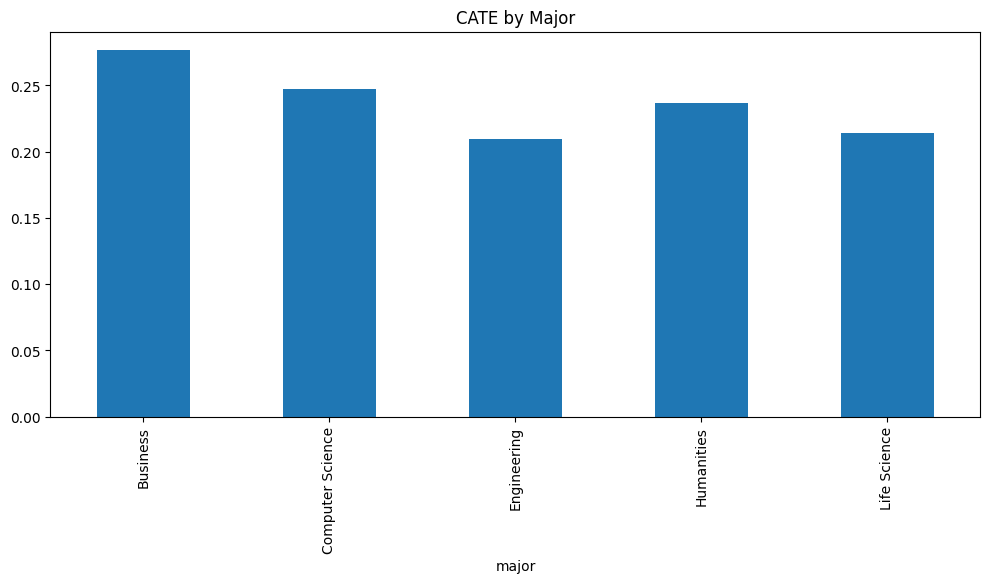

In [18]:
#| label: fig-cate-1
#| fig-cap: "CATE across Different Majors"

#Show CATE of sports pass across majors
fig, ax = plt.subplots(figsize=(12,5))

df.groupby(['major'])['cate'].mean().plot(ax=ax, kind='bar', title='CATE by Major');

To reiterate what the CATE represents, it is the incremental, or uplift, effect of our treatment. For example, business majors who purchase a sports pass experience, on average, a little more than a 25 percentage point increase in the probability of donating compared to those who do not purchase a sports pass. As we can see, the CATE is fairly different across majors. The effect of the sports pass appears to have the highest impact on Business and Computer Science majors, with the lowest being Engineering. However, since all these CATEs appear to be above 0.2, this strongly indicates that encouraging sports pass purchases can be an effective strategy to increase future donor likelihood among alumni.

We can further explore other covariates such as parent alumni status, as shown in @fig-cate-2.

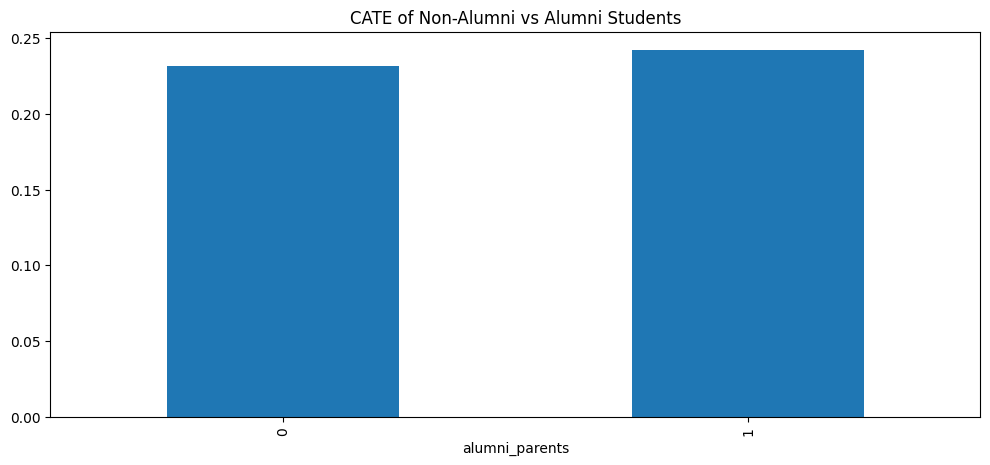

In [19]:
#| label: fig-cate-2
#| fig-cap: "CATE across Non-Alumni Parents vs Alumi Parents"

#Show CATE by alumni
fig, ax = plt.subplots(figsize=(12,5))

(df.assign(high_gpa = lambda x: np.where(x['GPA'] >= 3.5, 1, 0))
 .groupby(['alumni_parents'])['cate']
 .mean()
 .plot(kind='bar', ax=ax, title='CATE of Non-Alumni vs Alumni Students')
);

Building on the insights from @fig-cate-2, the CATEs appear quite similar and both remain positive. While we do not know the baseline probability of donation for these two categories, our analysis indicates that individuals within both groups react positively towards donating in the future when they purchase a sports pass.

# Conclusion

## Strategy Based on Analysis

Despite the relatively concise nature of our analysis, our findings are clearly impactful. Assuming the validity of our causal assumptions and sampling design, we have identified a controllable lever that universities can utilize to increase alumni donor likelihood. If these findings were to guide university strategy, actively encouraging more students to purchase sports passes would require careful strategic planning. For example, our analysis could inform targeted advertisements or promotions aimed at students identified as more likely future donors. Alternatively, the university might consider expanding the number of sports passes offered to broaden the pool of potential donors. Another valuable avenue for future research would be to further analyze which specific aspects of sports pass ownership cultivate stronger donor relations (e.g., fostering positive memories, facilitating social connections). In order to best utilize our findings, we would need to develop sound strategy on how to implement these findings and align it with the mission of the university. 

## Wrap-up

Overall, this simple analysis demonstrated key frameworks and models to help administrators identify levers within their university to increase philanthropic behavior from their alumni. While we made some strong assumptions on the validity of our data and the nature of our findings, the principles illustrated in this case study can be useful for many different scenarios. In the end, we hope this analysis provided you with the opportunity to see causal inference in action, from problem formulation to analysis and finally realizing that next steps include more strategic planning and research.